In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from IPython.display import display, Markdown
def short_print(text):
    display(Markdown(text+'\n'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
from reddit_thread_scraper import fetch_all_posts, build_dataframe_from_posts

# import dataset
thread_name = 'AmItheAsshole'
posts_num = 25000

posts = fetch_all_posts(thread_name, posts_num)

df = build_dataframe_from_posts(posts)

In [2]:
df.head()

,title,text,date,num_upvotes,num_comments,id,first_comment,first_comment_upvotes
0,AITA for calling out a bestfriend for ruining ...,My ex bestfriend is upset and calling me being...,01-04-2023,NaN,1,128fs8w,NTA- I guess she didn't like hearing the trut...,NaN
1,AITA for telling my Friend her Mother looks li...,I'll try to keep this short (please ignore gra...,01-04-2023,NaN,1,128frit,It's one thing to mix things up! It's another ...,NaN
2,AITA for singing at my friend's wedding?,I (24F) was a bridesmaid in my friend's (25F) ...,01-04-2023,NaN,1,128fpih,"NTA. Where I’m from, this sort of thing happen...",NaN
3,AITA for using outdated terminology to describ...,"I have autism, but it was classified as asperg...",01-04-2023,NaN,1,128flwe,NTA. I still identify with the term. But I've ...,NaN
4,WIBTA if I would sue my parents for animal abuse?,"Hello, throwaway for obvious reasons.\n\nI (18...",01-04-2023,NaN,1,128fl9c,It would definitely be blowing everything way ...,NaN


In [ ]:
df['NTA'] = np.where(df['first_comment'].str.contains('NTA'), 1, 0)

df['text'] = df[ 'text' ].apply( str )
df['text_len'] = df[ 'text' ].apply( len )

# Consider only texts shorter than appr. 512 tokens. 
df = df[ (df['text_len'] < 500*4) & (df['num_upvotes'] > 1) ].copy()

df['first_comment'] = df[ 'first_comment' ].apply( str )
df['first_comment_len'] = df[ 'first_comment' ].apply( len )

df_short = df[ (df['first_comment_len'] > 5*4)  ]

## Text clustering. Why dendrogram?

The main reason is the Hierarchical Nature of AITA Topics.

AITA posts tend to have complex themes, often involving nuanced relationships, emotions, and interactions. Hierarchical clustering allows for building a tree-like structure (dendrogram). That groups similar posts at multiple levels, and texts are represented by clusters that branch out into more specific subclusters.


In [4]:
from sentence_transformers import SentenceTransformer

embedding_model_name = 'mixedbread-ai/mxbai-embed-large-v1'

embedding_model = SentenceTransformer(embedding_model_name)

embeddings = embedding_model.encode(df_short['text'].to_list())
df_short['text_embeddings'] = embeddings.tolist()

2024-08-26 07:52:15.357736: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 07:52:15.360297: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 07:52:15.366868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 07:52:15.377293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 07:52:15.380309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-26 07:52:15.389352: I tensorflow/core/platform/cpu_feature_gu

In [5]:
from sklearn.decomposition import PCA

embeddings = np.array(df_short['text_embeddings'].tolist())

# Fit PCA to the data
pca = PCA().fit(embeddings)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 95% of the variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1 

print(f"Number of components that explain 95% of variance: {n_components}")

# Apply PCA to reduce the dimensions
pca = PCA(n_components=n_components, random_state=101) 

reduced_embeddings = pca.fit_transform(embeddings)

Number of components that explain 95% of variance: 281


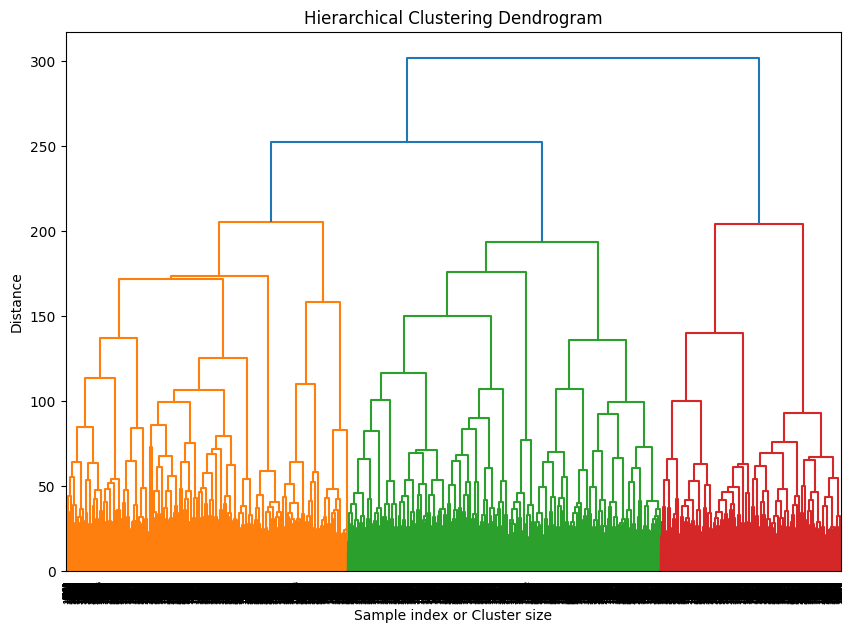

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Perform hierarchical/agglomerative clustering
linked = linkage(reduced_embeddings, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index or Cluster size')
plt.ylabel('Distance')
plt.show()

In [7]:
# Maximum linkage distance (the largest t value)
max_t = np.max(linked[:, 2])
print(f"Maximum linkage distance: {max_t}")

# Define percentage thresholds for cutting the dendrogram
thresholds = [0.8, 0.6, 0.4]  

for threshold in thresholds:
    # Calculate the distance at this percentage threshold
    t_value = threshold * max_t
    
    # Apply hierarchical clustering with this threshold
    clusters = fcluster(linked, t=t_value, criterion='distance')
    
    # Print or analyze the number of clusters
    n_clusters = len(np.unique(clusters))
    print(f"Threshold: {threshold*100}% | Number of clusters: {n_clusters}")
    df_short[f'cluster_{n_clusters}'] = clusters


Maximum linkage distance: 302.0119029259698
Threshold: 80.0% | Number of clusters: 3
Threshold: 60.0% | Number of clusters: 6
Threshold: 40.0% | Number of clusters: 15


In [14]:
list_of_clusters = [col for col in df_short.columns if col.startswith('cluster_')]

pd.crosstab(df_short[list_of_clusters[0]], df_short[list_of_clusters[1]])

cluster_6,1,2,3,4,5,6
cluster_3,,,,,,
1,1491,1461,0,0,0,0
2,0,0,2088,3059,0,0
3,0,0,0,0,1095,3551


In [15]:
pd.crosstab(df_short[list_of_clusters[1]], df_short[list_of_clusters[2]])

cluster_15,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
cluster_6,,,,,,,,,,,,,,,
1,1491,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,613,848,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1191,897,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,422,1021,1616,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,473,622,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,460,275,1464,436,916


## The topic of the drama:

### Keywords: Patterns vs. Embeddings 

Extracting Keywords with KeyBERT and SpaCy

AITA posts are were messy and often vague, so finding to compress the information is paramout. There are a number of methods, but in this project we are considering two: semantic similarity and extracting tyical patterns.

**Why SpaCy?**

spaCy allowes to extract syntactic patterns like noun or adjective phrases, which are useful in capturing repeated structures in like "bad decision" or "family conflict."

**Why KeyBERT?**

KeyBERT uses embeddings to capture the contextual meaning of the text. This is especially useful when processing multiple texts that don't necessarily use the same words or phrases but still revolve around the same underlying topic.



### - First, we are looking for recurring patterns within each post.

In [ ]:
import spacy
from spacy.matcher import Matcher
from collections import Counter

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")
# Initialize matcher
matcher = Matcher(nlp.vocab)

def get_word_paterns( text, matcher=matcher):
    pattern = [{"POS": "NOUN", "OP": "+"}]  
    matcher.add("NOUN_PHRASES", [pattern])

    adj_noun_pattern = [
        {"POS": "ADJ", "OP": "+"},  
        {"POS": "NOUN", "OP": "+"} 
    ]

    matcher.add("ADJ_NOUN_PHRASE", [adj_noun_pattern])

    doc = nlp(text)

    matches = matcher(doc)
    keywords = [doc[start:end].text for match_id, start, end in matches]

    unique_phrases = set(keywords)
    filtered_phrases = list(unique_phrases)
    words_to_remove = set()

    for phrase in filtered_phrases:
        words_in_phrase = phrase.split()
        if len(words_in_phrase) > 1:
            words_to_remove.update(words_in_phrase)

    final_keywords = [phrase for phrase in filtered_phrases if phrase not in words_to_remove]

    return ' '.join(final_keywords)

df_short['keywords'] = df_short['text'].apply( lambda x: get_word_paterns(x) ) 


### - Second, we are looking for keywords, summarizing a whole cluster of posts

In [8]:
from keybert import KeyBERT

kw_model = KeyBERT()

def get_KeyBert(text, kw_model=kw_model):
    keywords = kw_model.extract_keywords(text, 
                                         keyphrase_ngram_range=(1,2), 
                                         stop_words='english', 
                                         use_maxsum=False, 
                                         top_n=30)
    keywords = [ keyword[0] for keyword in keywords ]

    return ' '.join(keywords)


In [9]:
clusters_keyword = []

# Make doulble check all patterns are converted into strings
df_short['keywords'] = df_short['keywords'].apply( str )

# Iterate over all cluster columns that start with 'cluster_'
for split in [col for col in df_short.columns if col.startswith('cluster_')]:
    # Group by cluster and apply KeyBERT to extract keywords relevant to the whole group of texts
    cluster_keywords = df_short.groupby(split)['keywords'].apply(
        lambda texts: get_KeyBert(' '.join(texts))
    )
    
    clusters_keyword.append(cluster_keywords.tolist())


### Draw it out

In [10]:
from matplotlib.patches import Rectangle

# Function to keep only nouns and lemmatize them
def text_nouns(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    # Get POS tags for each word
    tags = nltk.pos_tag(words)
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Keep only nouns and lemmatize
    nouns = [lemmatizer.lemmatize(word, pos=wordnet.NOUN) for word, tag in tags if tag.startswith('NN')]
    return ' '.join(nouns)

# Updated word cloud function that returns the word cloud object for plotting
def word_cloud(list_of_text, top_n_words=10):
    # Create a CountVectorizer to count word frequencies
    top_topics_vectorizer = CountVectorizer(stop_words='english', preprocessor=text_nouns)
    
    # Fit and transform the text data for the specific cluster
    top_1 = top_topics_vectorizer.fit_transform([list_of_text])
    
    cluster_words = pd.DataFrame({
        'word': top_topics_vectorizer.get_feature_names_out(),  
        'counts': top_1.toarray().sum(axis=0)
    })
    
    # Sort by word counts and take the top_n_words most common words
    cluster_words = cluster_words.sort_values(by='counts', ascending=False).head(top_n_words)
        
    # Convert dataframe to dictionary for word cloud generation
    word_counts = dict(zip(cluster_words['word'], cluster_words['counts']))
    
    # Generate word cloud
    wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(word_counts)
    
    # Generate top 3 words to represent the topic
    top_3 = ' - '.join(cluster_words['word'][0:3].tolist())
    
    return wordcloud, top_3

# Draw all word clouds in one row
def draw_all_wordclouds(clusters_keyword, top_n_words=10):
    cluster_theme = {}
    num_clusters = len(clusters_keyword)
    
    # Set up the plot with 1 row and num_clusters columns, making each plot a square
    fig, axes = plt.subplots(1, num_clusters, figsize=(num_clusters * 6, 6))
    
    # If there's only one cluster, axes won't be an array, so we handle that case
    if num_clusters == 1:
        axes = [axes]
    
    for i in range(num_clusters):
        # Extract texts and generate the word cloud for each cluster
        texts = clusters_keyword[i]
        wordcloud, top_3 = word_cloud(texts, top_n_words)  # Use i + 1 for cluster numbering
        cluster_theme[i + 1] = top_3
        
        # Plot the word cloud on the respective axis
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'Cluster {i + 1}: {top_3}', fontsize=10)
        axes[i].axis('off')  # Turn off axis for a clean look

        # Add a black boundary around each word cloud
        rect = Rectangle((0, 0), 1, 1, transform=axes[i].transAxes, color='black', fill=False, lw=3)
        axes[i].add_patch(rect)

    # Adjust layout to ensure titles and plots fit nicely
    plt.tight_layout()
    plt.show()
    
    return cluster_theme

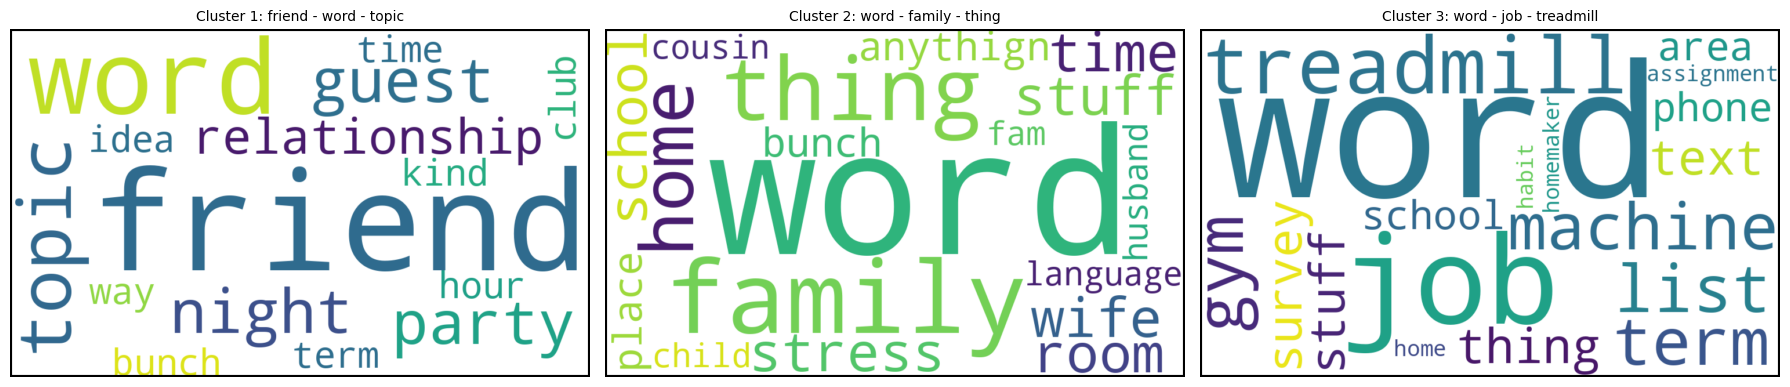

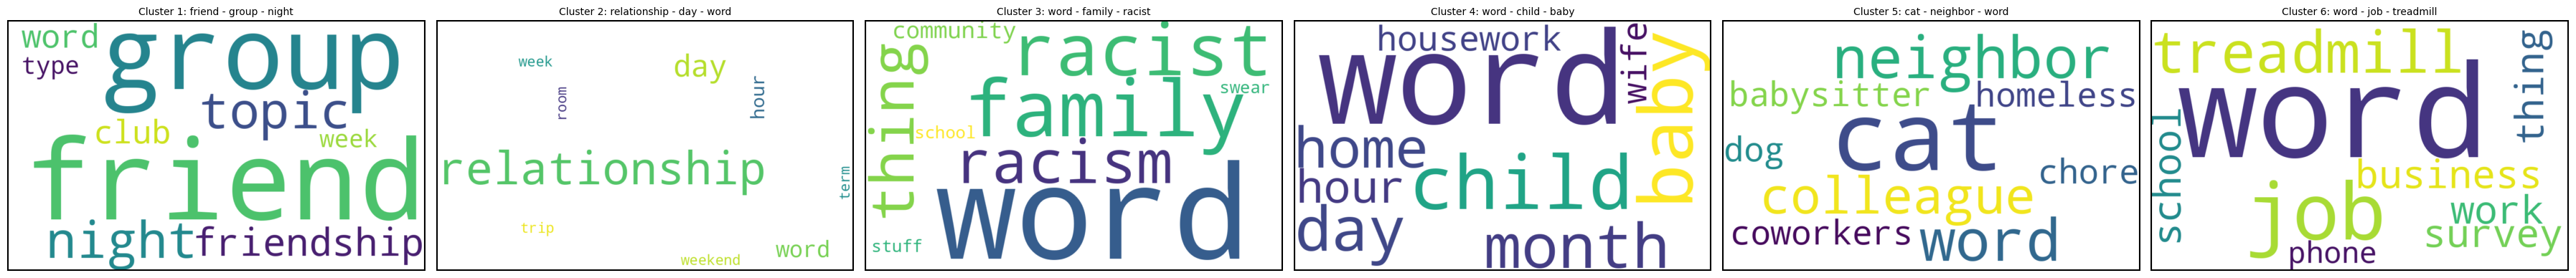

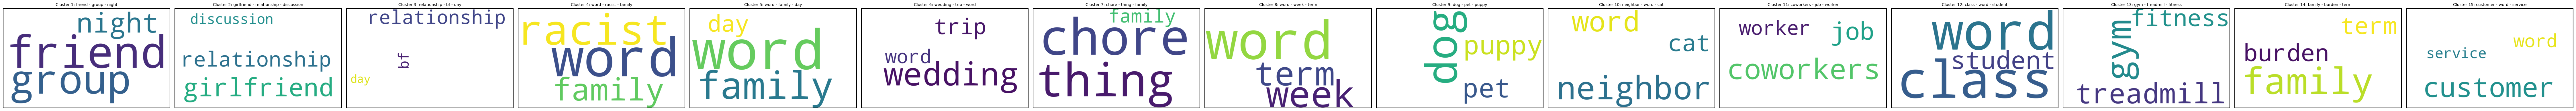

In [11]:
cluster_theme = draw_all_wordclouds(clusters_keyword[0], top_n_words=18)
cluster_theme = draw_all_wordclouds(clusters_keyword[1], top_n_words=9)
cluster_theme = draw_all_wordclouds(clusters_keyword[2], top_n_words=3)

## Topic hierarchy: 

In [12]:
def generate_word_clouds_for_splits(df_short, list_of_clusters, clusters_keyword, cluster_num, number_of_splits, top_n_words=10):
    for split_index in range(number_of_splits):
        # Crosstab and process for the current set of clusters
        if split_index == 0:
            crosstab_result = pd.crosstab(df_short[list_of_clusters[0]], df_short[list_of_clusters[0]])
        else:
            crosstab_result = pd.crosstab(df_short[list_of_clusters[0]], df_short[list_of_clusters[split_index]])

        non_zero_clusters = crosstab_result.iloc[cluster_num][crosstab_result.iloc[cluster_num] != 0].index.tolist()

        # Create a figure with a grid of plots, keeping consistent sizing and centering
        fig, axes = plt.subplots(nrows=1, ncols=len(non_zero_clusters), figsize=(3*len(non_zero_clusters), 3), constrained_layout=True)

        # Handle single subplot scenario
        if len(non_zero_clusters) == 1:
            axes = [axes] 

        # Loop over non_zero_clusters and generate word clouds
        for i, cls in enumerate(non_zero_clusters):
            wordcloud, top_words = word_cloud(clusters_keyword[split_index][cls-1], top_n_words=top_n_words)
            axes[i].imshow(wordcloud, interpolation='bilinear')
            #axes[i].set_title(f"Cluster: {top_words}", fontsize=12)
            axes[i].axis("off")

        # Make sure all plots are the same size and positioned centrally
        if len(non_zero_clusters) < len(axes):
            for ax in axes[len(non_zero_clusters):]:
                ax.remove()

        # Show the word cloud figure
        plt.show()


TOPIC 1


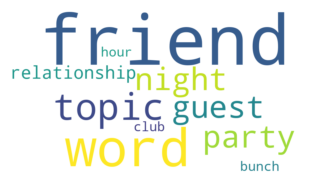

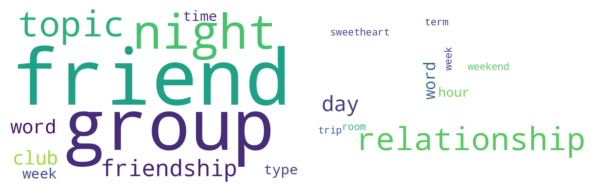

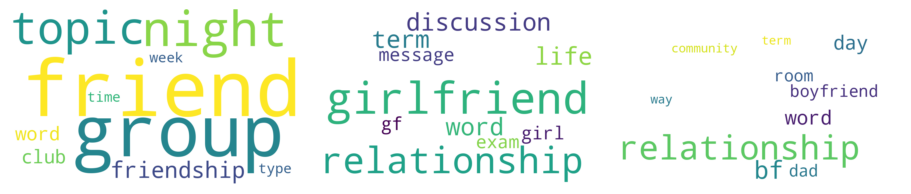

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
TOPIC 2


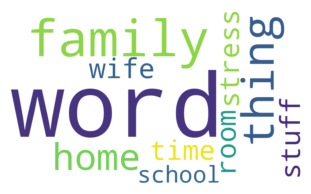

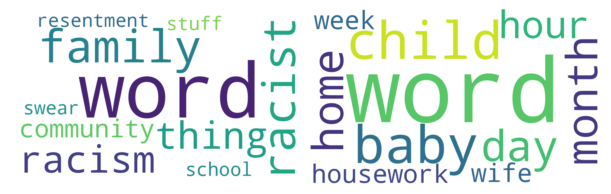

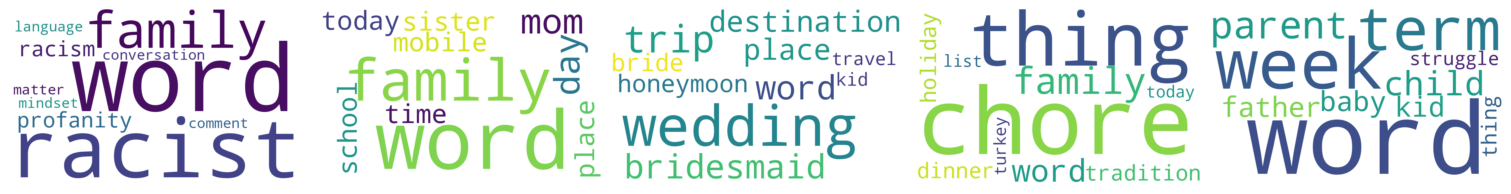

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
TOPIC 3


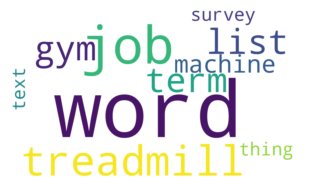

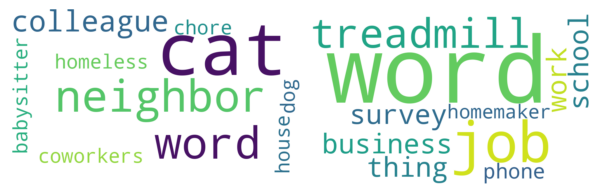

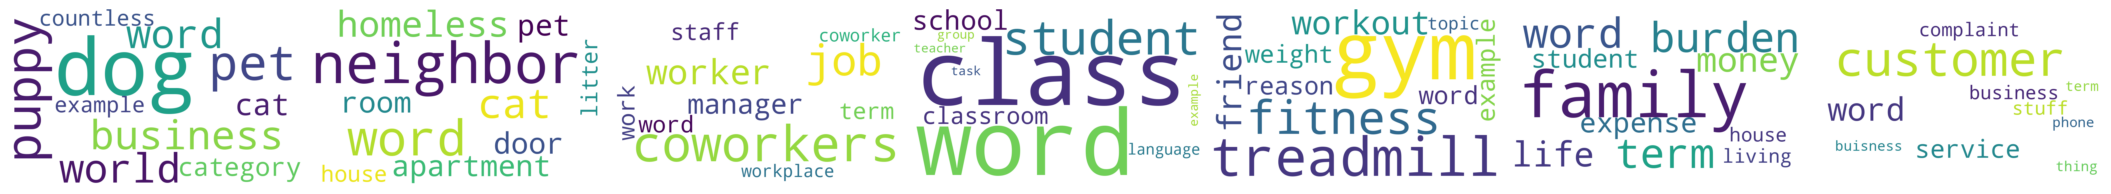

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


In [26]:
number_of_splits = len(thresholds)

for cluster_num in range(number_of_splits):
    print(f'TOPIC {cluster_num+1}')
    generate_word_clouds_for_splits(df_short, list_of_clusters, clusters_keyword, cluster_num=cluster_num, number_of_splits=number_of_splits, top_n_words=10)
    print('-*'*40)


## The best cluster representative... readable

**Identify the most representative text within a group of clustered data**. A function calculats the of all the text embeddings in a cluster and then finding the text that is closest to that centroid.

**Write a summery**. Once the most representative text is identified, LLM takes over. A function interacts Groq's API, and requests to generate a concise summary of the selected text. 

The two step approach help to distill complex content into clear representative.

In [24]:
def get_text_to_centroids(df, cluster_column, text_column, vector_column):
    
    embeddings = np.array(df[vector_column].tolist())

    # Initialize an empty list to store the most representative text for each cluster
    representative_texts = []

    # For each cluster, find the text closest to the centroid
    for cluster_num in sorted(df[cluster_column].unique()):
        # Get the embeddings of all texts in the cluster
        cluster_embeddings = embeddings[df[cluster_column] == cluster_num]
        
        # Ensure there are embeddings to process
        if len(cluster_embeddings) == 0:
            continue
        
        # Get the centroid of the cluster
        cluster_centroid = cluster_embeddings.mean(axis=0)
        
        # Find the index of the closest text to the centroid
        closest, _ = metrics.pairwise_distances_argmin_min([cluster_centroid], cluster_embeddings)
        
        # Get the original index of the closest text
        original_index = df[df[cluster_column] == cluster_num].index[closest[0]]
        
        # Append the most representative text (title or post) to the list
        representative_texts.append(df.loc[original_index, text_column])

    return representative_texts


In [ ]:
from groq import Groq

# Groq API key
client_grq = Groq(api_key="YOUR_KEY")

def get_groq_response(prompt, instruction, model="gemma-7b-it"):
    
    try:

        completion = client_grq.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "system","content": instruction
                },
                {
                    "role": "user", "content": prompt
                }
            ],
            temperature=0.2,
            max_tokens=500,
            top_p=1,
            stream=True,
            stop=None,
        )

        string = ''
        for chunk in completion:
            string += chunk.choices[0].delta.content or ""
        string = string.replace('\n', ' ')

        return string 

    except Exception as e:
        print(f"An error occurred: {e}")
        return "No information"  # or return None, based on how you want to handle errors



In [25]:
# Display the most representative text for each cluster

instr = 'Summarize the story in one sentance. Define a key problem of the narrator'

representative_texts =  get_text_to_centroids(df_short, 'cluster_6',  'text', 'text_embeddings')

print("---------------------------------------------------------")

for i, text in enumerate(representative_texts):
    summary = get_groq_response(text, instr, model="gemma-7b-it")
    short_print(f"Cluster {i+1}: {summary}")

---------------------------------------------------------


Cluster 1: **Story Summary:**  The narrator feels responsible for an argument that erupted during a hangout, where a friend accused her of ignoring his emotional distress.  **Key Problem:**  The narrator struggles with introversion and often avoids conflict, leading to feelings of inadequacy and a sense of responsibility for misunderstandings or hurt feelings of others.


Cluster 2: **Summary:** The narrator in Southeast Asia dislikes a friend of his girlfriend's and wants to leave the group trip but feels guilty about the potential conflict it might cause for his girlfriend and her friends.  **Key Problem:** The narrator's intense dislike for his girlfriend's friend, Vicky, is causing significant emotional distress and hindering his enjoyment of the trip.


Cluster 3: **Summary:** The narrator, an autistic teenager, experiences emotional distress after witnessing a family argument and struggles to cope with her emotions, leading to a crisis that involves school intervention and family conflict.  **Key Problem:** The narrator struggles with sensory sensitivities and emotional regulation, making it difficult for her to cope with conflict and express herself effectively.


Cluster 4: **Summary:** A family struggles to accommodate their son's teenage angst and logistical limitations when hosting a birthday gathering with his girlfriend and her boyfriend.  **Key Problem:** The son feels disrespected and unwanted by his mother's decision to prioritize the boyfriend's presence over his own comfort and wants.


Cluster 5: **Story Summary:** The narrator's roommate's untrained dog caused extensive damage in their room, including ruining an expensive bodysuit. The narrator is demanding compensation for the damaged item from their roommate.  **Key Problem:** The narrator's roommate's neglectful training of the dog, leading to ongoing damage and financial burden for the narrator.


Cluster 6: **Story Summary:** The narrator collects cans and bottles from parks for extra income, but when her partner's family criticizes the practice, her partner defends the narrator but later denies any involvement.  **Key Problem:** The narrator's partner's sudden disapproval and apparent hypocrisy regarding her side hustle after his family's negative reaction.


## Get Mood

### Let's look into the Main Sentiment

In [17]:
from transformers import pipeline

# Initialize sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis', truncation=True)

def get_sentiment(text):
    result = sentiment_pipeline(text)
    return result[0]['label']

df_short['sentiment'] = df_short['text'].apply( get_sentiment )

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


A quick look at average numbers:

In [18]:
print('Average number of upvotes by sentiments: ')
df_short.groupby(['sentiment'])['num_upvotes'].agg('mean')

Average number of upvotes by sentiments: 


sentiment
NEGATIVE    346.620898
POSITIVE    203.493827
Name: num_upvotes, dtype: float64

## Is there a combination topic + sentiment that performs better?

In [23]:
import scipy.stats as stats

mood_counts_by_cluster = df_short.groupby(['cluster_15', 'sentiment']).size().unstack(fill_value=0)

# Run chi-square test of independence
chi2, p, dof, expected = stats.chi2_contingency(mood_counts_by_cluster)

print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")

# If the p-value is below 0.05, it indicates that there is a significant association between clusters and moods
if p < 0.05:
    print("There is a significant association between certain mood-cluster combinations.")
else:
    print("No significant association was found between mood-cluster combinations.")

print(f"-*"*40)

# Convert the observed and expected arrays into DataFrames for easier analysis
observed_df = pd.DataFrame(mood_counts_by_cluster, index=mood_counts_by_cluster.index, columns=mood_counts_by_cluster.columns)
expected_df = pd.DataFrame(expected, index=mood_counts_by_cluster.index, columns=mood_counts_by_cluster.columns)

# Calculate the contribution to the chi-square statistic for each cell
contributions = (observed_df - expected_df) ** 2 / expected_df

# Top 10 mood-cluster combinations contributing to chi-square statistic
top_contributions = contributions.stack().sort_values(ascending=False).head(10)

# Map clusters to themes using cluster_theme dictionary and print the result
for (cluster, mood), contribution in top_contributions.items():
    print(f"-"*40)
    theme = cluster_theme.get(cluster, "Unknown Theme")  # Get the theme for the cluster
    print(f"Theme: {theme} \nSentiment: {mood} \nContribution to Chi-Square: {contribution:.4f}")



Chi-Square Statistic: 70.77993742174743
p-value: 1.393709899058229e-09
Degrees of Freedom: 14
There is a significant association between certain mood-cluster combinations.
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
----------------------------------------
Theme: customer - word - service 
Sentiment: POSITIVE 
Contribution to Chi-Square: 15.1614
----------------------------------------
Theme: girlfriend - relationship - discussion 
Sentiment: POSITIVE 
Contribution to Chi-Square: 11.3800
----------------------------------------
Theme: neighbor - word - cat 
Sentiment: POSITIVE 
Contribution to Chi-Square: 8.7393
----------------------------------------
Theme: relationship - bf - day 
Sentiment: POSITIVE 
Contribution to Chi-Square: 7.4188
----------------------------------------
Theme: gym - treadmill - fitness 
Sentiment: POSITIVE 
Contribution to Chi-Square: 5.6818
----------------------------------------
Theme: dog - pet - puppy 
Sentiment: POSIT

## To be continued... 